# singleline_dataset

> Processing Single Line Drawing Data to Train SketchRNN

## Install

```sh
pip install singleline_dataset
```

## Usage

### Converting SVG's to Stroke-3

In [ ]:
from singleline_dataset.transforms import *
from singleline_dataset.svg_files import *
from singleline_dataset.strokes import *
from singleline_dataset.display import *

# maximum number of points when discretizing the paths of the SVG file
total_n = 1000

# minimum number of points in a path, discard any paths with less points
min_n = 10

# process the SVG paths
rescaled_strokes = svg_to_strokes('../data/svg/0008.svg', total_n=total_n, min_n=min_n)

# recursively join up any paths whose start/end points are within a
# distance threshold of any other paths' start/end points
joined_strokes, _ = merge_until(rescaled_strokes, dist_threshold=15.0)

# recursively splice up any paths whose start/end points are within a
# distance threshold ANY POINTS WITHIN another path.
spliced_strokes, _ = splice_until(joined_strokes, dist_threshold=40.0)

# convert the strokes (lists of lists of coordinates)
# to stroke-3 format (list of coordinates + lift_pen field),
# and apply RDP stroke simplification to reduce the number
# of points.
deltas = stroke_rdp_deltas(spliced_strokes, epsilon=0.5)

Plotting each of the various transformations helps to explain what's happening at each stage of path processing:

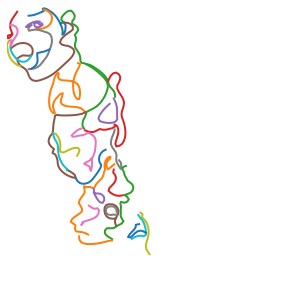

In [ ]:
plot_strokes(rescaled_strokes)

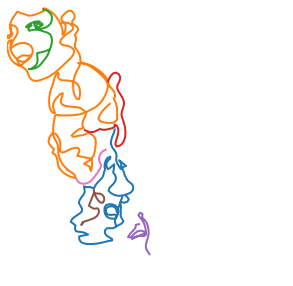

In [ ]:
plot_strokes(joined_strokes)

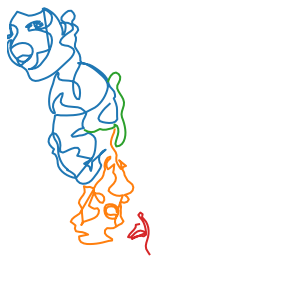

In [ ]:
plot_strokes(spliced_strokes)

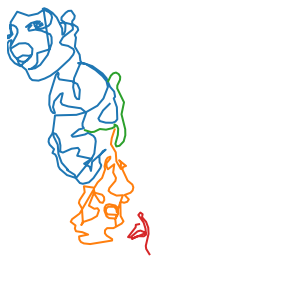

In [ ]:
plot_strokes(deltas_to_strokes(deltas))

### Working with Stroke-3 Data

The datasets for SketchRNN are based on Google's [QuickDraw dataset](https://github.com/googlecreativelab/quickdraw-dataset).

Each numpy `npz` file has a `train` and `valid` entry, each of which is an array of stroke-3 data.

In [ ]:
# download a dataset
!wget https://storage.googleapis.com/singleline-datasets/v1/epoch-20231214-trainval.npz

--2024-03-09 21:50:41--  https://storage.googleapis.com/singleline-datasets/v1/epoch-20231214-trainval.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:81e::201b, 2607:f8b0:4006:81d::201b, 2607:f8b0:4006:824::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:81e::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16584598 (16M) [application/octet-stream]
Saving to: ‘epoch-20231214-trainval.npz.2’

epoch-20231214-trai 100%[===================>]  15.82M  46.9MB/s    in 0.3s    

2024-03-09 21:50:42 (46.9 MB/s) - ‘epoch-20231214-trainval.npz.2’ saved [16584598/16584598]



In [ ]:
import numpy as np

ds = np.load('epoch-20231214-trainval.npz', encoding='latin1', allow_pickle=True)['train']
print(f"num drawings in dataset: {ds.shape[0]}")

ds[1][:5]

num drawings in dataset: 2400


array([[0.0, 70.17511113473614, 0.0],
       [3.5628420515071895, 10.158300414396564, 0.0],
       [3.9570533499574054, 6.056198233013305, 0.0],
       [-0.7156819364732456, -3.692830289126249, 0.0],
       [7.309693891169843, 4.8343845911431345, 0.0]], dtype=object)

#### Stroke-3 Transformations

It's helpful to convert back and forth between the formats **`deltas`**, **`points`**, and **`strokes`**.

**`deltas`** is what I call stroke-3 formatted data. It's one list of entries with the following format:

- `delta_x`
- `delta_y`
- `lift_pen` (`0` if pen is down, `1` if the pen should lift and start a new stroke)

**`points`** is like `deltas`, except with absolute coordinates instead of deltas. This is helpful for understanding the upper/lower x and y boundaries for a drawing.

- `abs_x`
- `abs_y`
- `lift_pen`

**`strokes`** is a list of lists of coordinates. Instead of needing a `lift_pen` column, each stroke is a separate list of absolute coordinates:

- `abs_x`
- `abs_y`

`singleline_dataset.transforms` provides the following converter functions:

- `deltas_to_points`
- `points_to_strokes`
- `deltas_to_strokes`
- `strokes_to_deltas`
- `strokes_to_points`
- `points_to_deltas`

In [ ]:
from singleline_dataset.transforms import *

points = deltas_to_points(ds[1])

points[:5]

array([[0.0, 70.17511113473614, 0.0],
       [3.5628420515071895, 80.3334115491327, 0.0],
       [7.519895401464595, 86.38960978214601, 0.0],
       [6.804213464991349, 82.69677949301976, 0.0],
       [14.113907356161192, 87.5311640841629, 0.0]], dtype=object)

In [ ]:
strokes = deltas_to_strokes(ds[1])

strokes[0][:5]

array([[0.0, 70.17511113473614, 0.0],
       [3.5628420515071895, 80.3334115491327, 0.0],
       [7.519895401464595, 86.38960978214601, 0.0],
       [6.804213464991349, 82.69677949301976, 0.0],
       [14.113907356161192, 87.5311640841629, 0.0]], dtype=object)

There are also helper functions for applying affine transformations to lists of `points`.

In [ ]:
_ = apply_transform(
    points[:,:2], # omit the lift_pen field to run affine transforms
    scale_xform(sx=2, sy=2).dot(rotate_xform(45))
)

There's a helper class to create a bounding box, given a list of points:

In [ ]:
bb = BoundingBox.create(points)
bb

BBox((0.0, 0.0), (39.35575901061327, 200.00000000000003)) (width 39.35575901061327 x height 200.00000000000003)

In [ ]:
bb.area()

7871.151802122655

In [ ]:
_ = apply_transform(
    points[:,:2],

    # affine transformation to scale the coordinates down to a range between 0 and 1 (preserving aspect ratio)
    bb.normalization_xform()
)

#### Displaying Stroke-3 Data

In [ ]:
from singleline_dataset.display import *

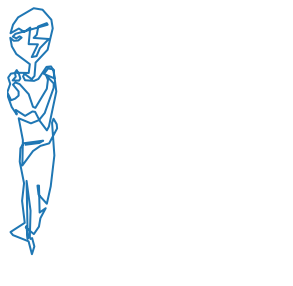

In [ ]:
plot_strokes(strokes)

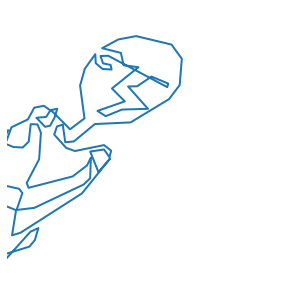

In [ ]:
transformed_points = apply_transform(
    points[:,:2], # omit the lift_pen field to run affine transforms
    translate_xform(tx=100,ty=0).dot(scale_xform(sx=2, sy=2)).dot(rotate_xform(45))
)

# add the lift_pen column back in after applying transformation
transformed_points = np.concatenate([transformed_points, points[:,2].reshape((transformed_points.shape[0], 1))], axis=1)

plot_strokes(points_to_strokes(transformed_points))